<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Eligible-population-stats" data-toc-modified-id="Eligible-population-stats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eligible population stats</a></span></li></ul></div>

This notebook is from Fall 2022. 
It uses the court data we scraped in October 2021 to model cannabis policy in VA. Note that this is so old I had to change a couple things to get it to work again, so probably worth cross referencing against other more recent policies that use the same dataset and it might warrant some preprocessing updates.

In [3]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data cleaning
Tip: you'll probably want to save the preprocessed file to a csv the first time you run this for a new policy and then import that csv from then on out to save time. To do so, uncomment the `df.to_csv()` line at the bottom of
this section, then after you run it move that file to `recidiviz-staging>recidiviz>calculator>modeling>population_projection>state>VA>VA_data`. From then on, you can skip everything in the data cleaning section and just run the file import commented out at the end of the section.

In [4]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [16]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

In [18]:
sdc_data

In [17]:
# Check sentencing data to determine age of offenders when sentenced
raw_sent = pd.concat([
    pd.read_csv(f'../../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)
])

under_25 = 0
total = 0

for i, row in raw_sent.iterrows():
    sentence_year = row['Calendar Year of Sentencing']
    birth_year = row['Offender Birth Year']
    
    sentencing_age = sentence_year - birth_year
        
    if sentencing_age <= 25:
        under_25 += 1
    
    total += 1
        
# Proportion of inmates incarcerated before 25
INCARCERATED_BEFORE_25 = under_25/total

In [15]:
sdc_data

# Preprocessing

## TODOs
* can't just drop 0 length sentences
* recidivism
* separate out jail
* total population (2019/2020 by month)

In [8]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor
outflows_data = outflows_data[(outflows_data['time_step'] > -108) & (outflows_data['time_step'] <= 33)]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

In [14]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type'
]).count()[['Address']].reset_index().rename({'Address': 'total_population'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    crime_recidivism = recidivism_transitions.copy()
    total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
    crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
    crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - crime_specific_total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime_type'] = crime
    
    transitions_data = transitions_data.append(crime_recidivism)
    
    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime_type == crime, 'total_population'
    ] /= 1 + crime_specific_total_recidivism


transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types),
    'total_population': [1] * len(crime_types),
    'compartment': ['release_full'] * len(crime_types),
    'outflow_to': ['release_full'] * len(crime_types),
    'crime_type': crime_types,
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

In [13]:
transitions_data.columns

In [11]:
#Create alternate transitions table for policy scenario

ETC_LEVEL_BY_CRIME = pd.DataFrame({
    'CONSPIRACY': {1:27, 2: 5, 3: 12, 4:7},
    'DRUG_POSSESSION': {1:574, 2:78, 3:177, 4:171},
    'DRUG_SALE': {1:1415, 2:245, 3:629, 4:458},
    'DRUG_OTHER': {1:1989, 2:323, 3:806, 4:629},
    'KIDNAPPING': {1:641, 2:203, 3:430, 4:304},
    'MANSLAUGHTER': {1:175, 2:44, 3:122, 4:96},
    'LARCENY': {1:1289, 2:190, 3:447, 4:591},
    'WEAPON': {1:346, 2:45, 3:100, 4:158},
    'ASSAULT': {1:1391, 2:354, 3:685, 4:728},
    'ROBBERY': {1:1491, 2:488, 3:1049, 4:1014},
    'BURGLARY': {1:740, 2:165, 3:413, 4:476},
    'DWI': {1: 101, 2: 14, 3: 28, 4:24},
    'RAPE': {1:1355, 2:304, 3:917, 4:405},
    'SEX_OFFENSE': {1:343, 2:60, 3:180, 4:80},
    'ARSON': {1:40, 2:13, 3:14, 4:26},
    'FIRST_DEGREE_MURDER': {1:868, 2:288, 3:534, 4:313},
    'SECOND_DEGREE_MURDER': {1:296, 2: 109, 3:224, 4:148},
    'OTHER_MURDER': {1:1327, 2:432, 3:833, 4:498},
    'CAPITAL_MURDER': {1:163, 2:35, 3:75, 4:37}
}).transpose()

LEVEL_ONE = ETC_LEVEL_BY_CRIME[1] / ETC_LEVEL_BY_CRIME.sum(axis=1)


# This estimates resentencing frequency/outcomes using the parole set-off system used in Texas
# see https://www.secondlooktexas.org/action
GRANT_RATE = 3 / (32 + 3)

# We don't have data on the distribution of set-off times after each hearing, so doing every other year
SETOFF_TIME = 24
alternate_transitions_data = pd.DataFrame()

# Months of sentence that must be served to be eligible for Second Look

# For people incarcerated before the age of 25
SENTENCE_LENGTH_A = 10*12
# For people incarcerated after the age of 25
SENTENCE_LENGTH_B = 15*12

for crime_type in crime_types:
    # isolate the transitions data just for prison and for this crime type
    crime_data = transitions_data[
        (transitions_data['crime_type'] == crime_type) 
        & (transitions_data['compartment'] == 'prison')
    ].copy()
    
    # since only level 1 people are eligible, we start by siphoning off just 
    # that percentage to have the policy effect
    eligible_data = crime_data.copy()
    # reduce the population size of non-impacted group by the same amount that will be added to the impacted group
    crime_data.total_population *= 1 - LEVEL_ONE[crime_type]
    # set population size of impacted group
    eligible_data.total_population *= LEVEL_ONE[crime_type]
    
    # Manually transition out of prison with a frequency of GRANT_RATE
    for i in range(SENTENCE_LENGTH_A, int(eligible_data.compartment_duration.max()), SETOFF_TIME):
        rate = GRANT_RATE
        
        # if less than 15 years, only applies to people younger than 25
        if i < SENTENCE_LENGTH_B:
            rate *= INCARCERATED_BEFORE_25
        
        # calculate population that still hasn't been released by now
        remaining_population = eligible_data.loc[
            eligible_data['compartment_duration'] > i, 'total_population'
        ].sum()
        
        # reduce the population size of people staying in prison longer than this by the number of people being
        # released via resentencing right now
        eligible_data.loc[eligible_data['compartment_duration'] > i, 'total_population'] *= 1 - rate
        
        # add in rows of data for the people being released right now via resentencing
        eligible_data = eligible_data.append({
            'compartment_duration': i,
            'total_population': rate*remaining_population,
            'crime_type': crime_type,
            'compartment': 'prison',
            'outflow_to': 'release'
        }, ignore_index=True)
    
    
    # recombine the unaffected population with the affected population. Since we're redoing the groupby in a sec,
    # we can do that just by concatenating the two dfs
    crime_data = pd.concat([crime_data, eligible_data])
        
    crime_data = crime_data.groupby([
        'compartment', 'compartment_duration', 'crime_type', 'outflow_to'
    ], as_index=False).sum()
    
    # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
    # so the last line of data has a tiny tiny population
    crime_data.loc[max(crime_data.index), 'total_population'] = max(crime_data.loc[max(crime_data.index), 'total_population'], 10**(-5))
    
    # append our work to the new transitions_data we're building
    alternate_transitions_data = alternate_transitions_data.append(crime_data)

# Round population numbers to avoid tiny populations in weird places
alternate_transitions_data.total_population = alternate_transitions_data.total_population.apply(lambda x: round(x, 5))
# drop the rows that are now rounded to zero
alternate_transitions_data = alternate_transitions_data[alternate_transitions_data.total_population > 0]

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data =

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(crime_data)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data =

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(crime_data)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(crime_data)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(crime_data)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:98: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(crime_data)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data =

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_3026/3041504192.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data =

In [12]:
CRIME_TYPE = 'ARSON'
alt_data = alternate_transitions_data[alternate_transitions_data.crime_type == 'DRUG_POSSESSION']
og_data = transitions_data[(transitions_data.crime_type == 'DRUG_POSSESSION') & (transitions_data.compartment == 'prison')]
alt_data.index = alt_data.compartment_duration
og_data.index = og_data.compartment_duration

display_df = pd.DataFrame()
display_df['og'] = og_data.total_population
display_df['alternate'] = alt_data.total_population

display_df

,og,alternate
compartment_duration,,
1.0,9939.0,9939.00000
2.0,5673.0,5673.00000
3.0,9319.0,9319.00000
4.0,3198.0,3198.00000
5.0,6405.0,6405.00000
6.0,1273.0,1273.00000
7.0,981.0,981.00000
8.0,1821.0,1821.00000
9.0,700.0,700.00000


In [13]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [14]:
simulation_tag = "second_look_second_pass"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../../state/VA/2022/policy_configurations/SLPR_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Forbidden: 403 GET https://bigquery.googleapis.com/bigquery/v2/projects/recidiviz-staging/datasets/spark_public_input_data/tables/outflows_data_raw?prettyPrint=false: Access Denied: Table recidiviz-staging:spark_public_input_data.outflows_data_raw: Permission bigquery.tables.get denied on table recidiviz-staging:spark_public_input_data.outflows_data_raw (or it may not exist).

# Modeling

In [15]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/VA/2022/policy_configurations/SLPR_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/stanford-decarceration-collective-VLMPOYfe/lib/python3.8/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


GenericGBQException: Reason: 403 Access Denied: Table recidiviz-staging:spark_public_input_data.outflows_data_raw: User does not have permission to query table recidiviz-staging:spark_public_input_data.outflows_data_raw, or perhaps it does not exist in location US.

Location: US
Job ID: 42369214-673a-4fb3-a57f-f43c4e511a0e


..\..\..\..\..\recidiviz\calculator\modeling\population_projection\shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
..\..\..\..\..\recidiviz\calculator\modeling\population_projection\full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  1419.6228864192963


simulation_time:  460.8206253051758


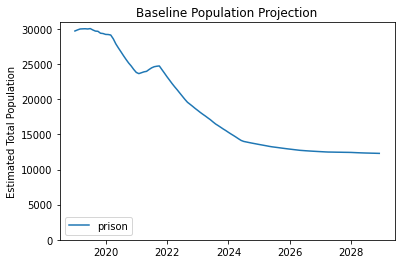

In [25]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

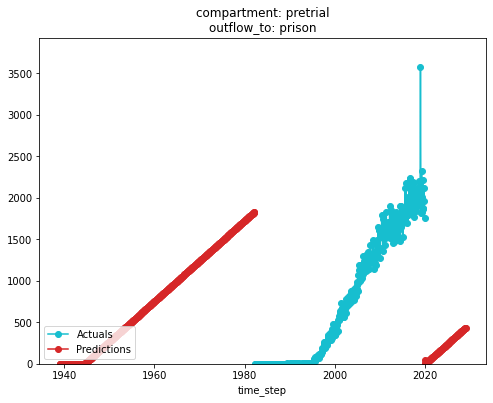

In [26]:
spark_sim.get_arima_output_plots('baseline_projections')

In [17]:
def second_look(crime):
    return partial(
        TransitionTable.use_alternate_transitions_data, 
        alternate_historical_transitions=alternate_transitions_data[
            alternate_transitions_data.crime_type == crime
        ],
        retroactive=True
    )

policy_list = []
for crime in crime_types:
    policy_list.append(SparkPolicy(policy_fn=second_look(crime),
           spark_compartment='prison',
           sub_population={'crime_type': crime},
           policy_ts=42,
           apply_retroactive=True))

test_results = spark_sim.simulate_policy(policy_list, 'prison')



KeyboardInterrupt: 

C:\Users\isaac\AppData\Local\Temp/ipykernel_8504/2360662352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['t'] = a.total_population.cumsum() / a.total_population.sum()


<AxesSubplot:xlabel='compartment_duration'>

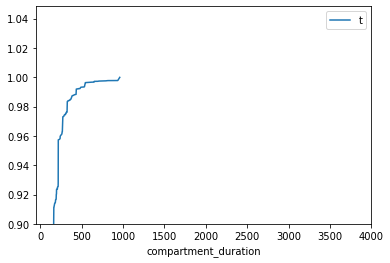

In [28]:
a = alternate_transitions_data[alternate_transitions_data.crime_type == 'RAPE']
a['t'] = a.total_population.cumsum() / a.total_population.sum()
a.plot(y='t', x='compartment_duration', ylim=[0.9,None], xlim=[None, 4000])

In [29]:
test_results[test_results.compartment == 'prison'].apply(lambda x: x.control_total_population - x.policy_total_population, axis=1)

year
2019.000000    0.000000
2019.083333    0.000000
2019.166667    0.000000
2019.250000    0.000000
2019.333333    0.000000
                 ...   
2028.583333    1.331550
2028.666667    1.338617
2028.750000    1.345505
2028.833333    1.351409
2028.916667    1.359870
Length: 2280, dtype: float64

In [30]:
for crime in crime_types:
    if alternate_transitions_data[alternate_transitions_data.crime_type == crime].compartment_duration.max() < 5:
        print(alternate_transitions_data[alternate_transitions_data.crime_type == crime])

In [31]:
simulation_tag = 'second_look_second_pass'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release
 year                                
 2019.000000              0.0     0.0
 2019.083333              0.0     0.0
 2019.166667              0.0     0.0
 2019.250000              0.0     0.0
 2019.333333              0.0     0.0
 2019.416667              0.0     0.0
 2019.500000              0.0     0.0
 2019.583333              0.0     0.0
 2019.666667              0.0     0.0
 2019.750000              0.0     0.0
 2019.833333              0.0     0.0
 2019.916667              0.0     0.0
 2020.000000              0.0     0.0
 2020.083333              0.0     0.0
 2020.166667              0.0     0.0
 2020.250000              0.0     0.0
 2020.333333              0.0     0.0
 2020.416667              0.0     0.0
 2020.500000              0.0     0.0
 2020.583333              0.0     0.0
 2020.666667              0.0     0.0
 2020.750000              0.0     0.0
 2020.833333              0.0     0.0
 2020.916667              0.0    

# Eligible population stats

In [32]:
remaining_by_sentence

NameError: name 'remaining_by_sentence' is not defined